# me 07.Z Homework 001.ipynb
Source: https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/cohorts/2022/07-bento-production/homework.md

In [1]:
import pandas as pda
import numpy as npy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

In [2]:
urlCsv = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'
dfr = pda.read_csv(urlCsv)
print(' shape = ' , dfr.shape)
#dfr.head().T

 shape =  (4455, 14)


In [3]:
dfr.columns = dfr.columns.str.lower()

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

dfr.status = dfr.status.map(status_values)

home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

dfr.home = dfr.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

dfr.marital = dfr.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

dfr.records = dfr.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

dfr.job = dfr.job.map(job_values)

for col in ['income', 'assets', 'debt']:
    dfr[col] = dfr[col].replace(to_replace=99999999, value=npy.nan)

dfr = dfr[dfr.status != 'unk'].reset_index(drop=True)

In [4]:
dfrTra, dfrTst = train_test_split(dfr, test_size=0.2, random_state=11)

dfrTra = dfrTra.reset_index(drop=True)
dfrTst = dfrTst.reset_index(drop=True)

y_Tra = (dfrTra.status == 'default').astype('int').values
y_Tst = (dfrTst.status == 'default').astype('int').values

del dfrTra['status']
del dfrTst['status']

In [5]:
!pip install xgboost

In [6]:
dvt = DictVectorizer(sparse=False)

dicTra = dfrTra.fillna(0).to_dict(orient='records')
X_Tra = dvt.fit_transform(dicTra)
dmaTra = xgb.DMatrix(X_Tra, label=y_Tra)

dicTst = dfrTst.fillna(0).to_dict(orient='records')
X_Tst = dvt.transform(dicTst)
dmaTst = xgb.DMatrix(X_Tst, label=y_Tst)

In [26]:
dicTra[23:24]

[{'seniority': 3,
  'home': 'owner',
  'time': 36,
  'age': 26,
  'marital': 'married',
  'records': 'no',
  'job': 'fixed',
  'expenses': 45,
  'income': 133.0,
  'assets': 26000.0,
  'debt': 0.0,
  'amount': 1000,
  'price': 1300}]

In [27]:
X_Tra[23:24] , y_Tra[23:24]

(array([[2.60e+01, 1.00e+03, 2.60e+04, 0.00e+00, 4.50e+01, 0.00e+00,
         0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         1.33e+02, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         0.00e+00, 1.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00,
         1.30e+03, 1.00e+00, 0.00e+00, 3.00e+00, 3.60e+01]]),
 array([0]))

In [20]:
dmaOne = xgb.DMatrix(X_Tra[23:24], label=y_Tra[23:24])

In [21]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthrebad': 8,
    'seed': 1,
    'verbosity': 1,
}

modXgb = xgb.train(xgb_params, dmaTra, num_boost_round=175)

[15:41:29] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "nthrebad" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [24]:
y_prdTst = modXgb.predict(dmaTst)
y_prdTst[23:24]

array([0.60935104], dtype=float32)

In [23]:
modXgb.predict(dmaOne)

array([0.02354733], dtype=float32)

## BentoML

In [9]:
#!pip install bentoml

In [10]:
import bentoml

In [11]:
bentoml.__version__

'1.0.7'

## Q1 = '1.0.7'

In [36]:
modBen = bentoml.xgboost.save_model(
    'credit_risk_model',
    modXgb,
    custom_objects={
        'dictVectorizer': dvt
    })

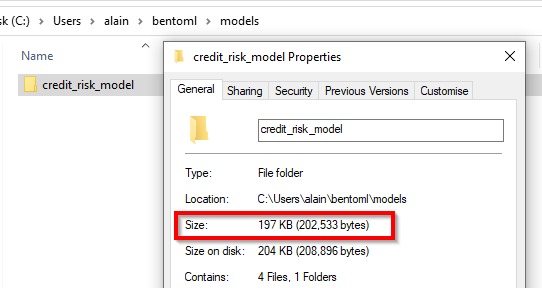

## Q2 = 197 KB

In [37]:
modBen.info.to_dict()

{'name': 'credit_risk_model',
 'version': 'rneewuso6sckunht',
 'module': 'bentoml.xgboost',
 'labels': {},
 'options': {'model_class': 'Booster'},
 'metadata': {},
 'context': {'framework_name': 'xgboost',
  'framework_versions': {'xgboost': '1.6.2'},
  'bentoml_version': '1.0.7',
  'python_version': '3.9.13'},
 'signatures': {'predict': {'batchable': False}},
 'api_version': 'v2',
 'creation_time': '2022-10-18T14:52:53.415105+00:00'}

In [38]:
modBen.path

'C:\\Users\\alain\\bentoml\\models\\credit_risk_model\\rneewuso6sckunht\\'

In [41]:
modBen.custom_objects

{'dictVectorizer': DictVectorizer(sparse=False)}

 Volume in drive C has no label.
 Volume Serial Number is E8A5-BC16

 Directory of C:\Users\alain\Documents\prv\IT\mlzc\jupyter

18/10/2022  23:14    <DIR>          .
18/10/2022  23:14    <DIR>          ..
17/10/2022  13:55    <DIR>          .ipynb_checkpoints
16/09/2022  11:29           167,411 02-carprice.ipynb
08/09/2022  09:36            56,323 09-pandas.ipynb
04/10/2022  15:42               333 dv.bin
14/10/2022  15:58            29,268 me 00 Draft.ipynb
23/09/2022  09:43             1,485 me 00 SHA1.ipynb
07/09/2022  18:09            19,991 me 01.7 Introduction to NumPy.ipynb
10/09/2022  20:52            15,622 me 01.8 Vectors and Matrix.ipynb
08/09/2022  10:24            81,111 me 01.9 Introduction to Pandas.ipynb
12/09/2022  08:23            28,547 me 01.Z Homework 001.ipynb
16/09/2022  11:20           256,344 me 02.a Data preparation and next.ipynb
16/09/2022  17:02            51,244 me 02.Z Homework 001.ipynb
22/09/2022  15:57           235,343 me 03.1 Churn prediction.ipynb


## Test pydantic

In [63]:
# installed pydantic with conda in mlzc
from pydantic import BaseModel

## Q3 = class below

In [64]:
class UserProfile(BaseModel):
    name : str
    age: int
    country : str
    rating : float

In [70]:
# a good one
dicOneOk = {
  "name": "Tim",
  "age": 37,
  "country": "US",
  "rating": 3.14
}

In [88]:
# a wrong one
dicOneNok = {
  "name": 35,
  "age": "What age?",
  "country": 1234,
  "rating": 4
}

In [89]:
print(UserProfile(**dicOneOk))

name='Tim' age=37 country='US' rating=3.14


In [107]:
try:
    print(UserProfile(**dicOneOk))
    print("*** OK ***")
except Exception as err:
    print("*** NOT OK *** Error: \n" , err)

name='Tim' age=37 country='US' rating=3.14
*** OK ***


In [108]:
try:
    print(UserProfile(**dicOneNok))
    print("*** OK ***")
except Exception as err:
    print("*** NOT OK *** Error: \n" , err)

*** NOT OK *** Error: 
 1 validation error for UserProfile
age
  value is not a valid integer (type=type_error.integer)


# Q4 Import Model

In [110]:
!curl --help

Usage: curl [options...] <url>
 -d, --data <data>          HTTP POST data
 -f, --fail                 Fail fast with no output on HTTP errors
 -h, --help <category>      Get help for commands
 -i, --include              Include protocol response headers in the output
 -o, --output <file>        Write to file instead of stdout
 -O, --remote-name          Write output to a file named as the remote file
 -s, --silent               Silent mode
 -T, --upload-file <file>   Transfer local FILE to destination
 -u, --user <user:password> Server user and password
 -A, --user-agent <name>    Send User-Agent <name> to server
 -v, --verbose              Make the operation more talkative
 -V, --version              Show version number and quit

This is not the full help, this menu is stripped into categories.
Use "--help category" to get an overview of all categories.
For all options use the manual or "--help all".


In [111]:
!curl -O https://s3.us-west-2.amazonaws.com/bentoml.com/mlzoomcamp/coolmodel.bentomodel

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100  1724  100  1724    0     0    685      0  0:00:02  0:00:02 --:--:--   685


In [118]:
!dir coolmodel.bentomodel

 Volume in drive C has no label.
 Volume Serial Number is E8A5-BC16

 Directory of C:\Users\alain\Documents\prv\IT\mlzc\jupyter

20/10/2022  10:03             1,724 coolmodel.bentomodel
               1 File(s)          1,724 bytes
               0 Dir(s)  97,209,556,992 bytes free


In [119]:
!bentoml models import coolmodel.bentomodel

Model(tag="mlzoomcamp_homework:qtzdz3slg6mwwdu5") imported


In [120]:
!type C:\Users\alain\bentoml\models\mlzoomcamp_homework\qtzdz3slg6mwwdu5\model.yaml

name: mlzoomcamp_homework
version: qtzdz3slg6mwwdu5
module: bentoml.sklearn
labels: {}
options: {}
metadata: {}
context:
  framework_name: sklearn
  framework_versions:
    scikit-learn: 1.1.1
  bentoml_version: 1.0.7
  python_version: 3.9.12
signatures:
  predict:
    batchable: false
api_version: v1
creation_time: '2022-10-13T20:42:14.411084+00:00'


## Q4 = scikit-learn: 1.1.1

# Q5: Create bentoml
The output type for this endpoint should be **NumpyNdarray()**

In [121]:
!python --version

Python 3.9.13


In [4]:
!type hw7_q5__service.py

print('***** Starting hw5_q5_service.py 18:10 *****')

import numpy as npy

import bentoml
from bentoml.io import JSON
from bentoml.io import NumpyNdarray

from pydantic import BaseModel

print('** Import completed**')

class UserProfile(BaseModel):
    name: str
    age: int
    country: str
    rating: float


print('** Get mmodel **')
modBnt = bentoml.sklearn.get("mlzoomcamp_homework:qtzdz3slg6mwwdu5")

print('** Run mmodel **')

modBntRun = modBnt.to_runner()


svc = bentoml.Service("hw7_q5_service", runners=[modBntRun])

@svc.api(input=NumpyNdarray(), output=JSON())

async def classify(UserProfile):
    print('** in classify **')
    print('> UserProfile :' , UserProfile)
    prd = await modBntRun.predict.async_run(UserProfile)
    print('> prd = ' , prd)
    return( { "prediction" : prd  })

"""
def classify(UserProfile):
    print('** in classify **')
    print('> UserProfile :' , UserProfile)
    prd = modBntRun.predict.run(UserProfile)
    print('> prd = ' , prd)
    return( {

# in miniconda (after activate):
- cd C:\Users\alain\Documents\prv\IT\mlzc\jupyter
- bentoml serve hw7_q5__service:svc --reload

See http://localhost:3000/

Input = [[6.4,3.5,4.5,1.2]]

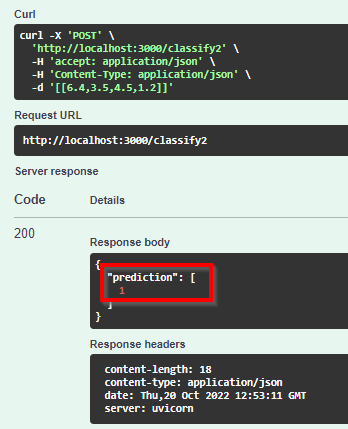

## Q5 = 1 

In [7]:
!type bentofile.yaml

# Same as `bentoml serve <service-name>`
service: "hw7_q5__service.py:svc"  

labels:
    owner: alain
    stage: dev

# all files to be loaded
include:
- "hw7_q5__service.py"  

# all package needed
python:
    packages:  
    - xgboost
    - pandas
    - sklearn
    - pydantic


### in conda:
- bentoml build

```
***** Starting hw5_q5_service.py 18:10 *****
** Import completed**
** Get mmodel **
** Run mmodel **
Building BentoML service "hw7_q5_service:tsjny7srdonq2nht" from build context "C:\Users\alain\Documents\prv\IT\mlzc\jupyter"
Packing model "mlzoomcamp_homework:qtzdz3slg6mwwdu5"
Locking PyPI package versions..
C:\Users\alain\miniconda3\envs\mlzc\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")

██████╗░███████╗███╗░░██╗████████╗░█████╗░███╗░░░███╗██╗░░░░░
██╔══██╗██╔════╝████╗░██║╚══██╔══╝██╔══██╗████╗░████║██║░░░░░
██████╦╝█████╗░░██╔██╗██║░░░██║░░░██║░░██║██╔████╔██║██║░░░░░
██╔══██╗██╔══╝░░██║╚████║░░░██║░░░██║░░██║██║╚██╔╝██║██║░░░░░
██████╦╝███████╗██║░╚███║░░░██║░░░╚█████╔╝██║░╚═╝░██║███████╗
╚═════╝░╚══════╝╚═╝░░╚══╝░░░╚═╝░░░░╚════╝░╚═╝░░░░░╚═╝╚══════╝

Successfully built Bento(tag="hw7_q5_service:tsjny7srdonq2nht")
```

### in conda:
- bentoml containerize hw7_q5_service:tsjny7srdonq2nht

```
Building docker image for Bento(tag="hw7_q5_service:tsjny7srdonq2nht")...
Successfully built docker image for "hw7_q5_service:tsjny7srdonq2nht" with tags "hw7_q5_service:tsjny7srdonq2nht"
To run your newly built Bento container, pass "hw7_q5_service:tsjny7srdonq2nht" to "docker run". For example: "docker run -it --rm -p 3000:3000 hw7_q5_service:tsjny7srdonq2nht serve --production".
```

### in conda:
- docker run -it --rm -p 3000:3000 hw7_q5_service:tsjny7srdonq2nht serve --production

See http://localhost:3000/

Input = [[6.4,3.5,4.5,1.2]]

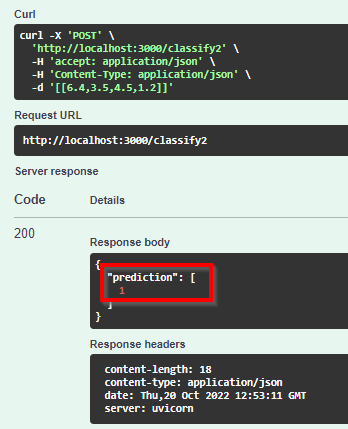

# Q6 : Performance

### In conda:
- bentoml serve hw7_q5__service:svc --reload **--production**

In [5]:
#!pip install locust

### a) in miniconda bentoml + activate:
- cd C:\Users\alain\Documents\prv\IT\mlzc\jupyter
- bentoml serve hw7_q5__service:svc --reload **--production**
- check at http://localhost:3000/ that serrvice works
- open a second miniconda3 + activate

### b) in miniconda locust (an other one)
- cd C:\Users\alain\Documents\prv\IT\mlzc\jupyter
- locust -H http://localhost:3000
- check at http://localhost:8089 that locust works (default 1 user each second)  

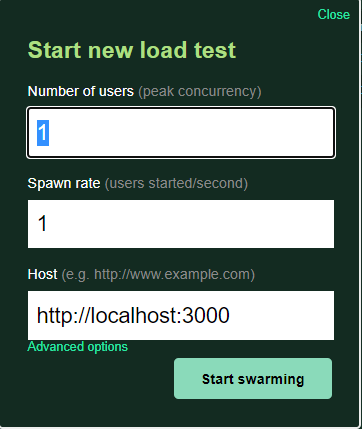

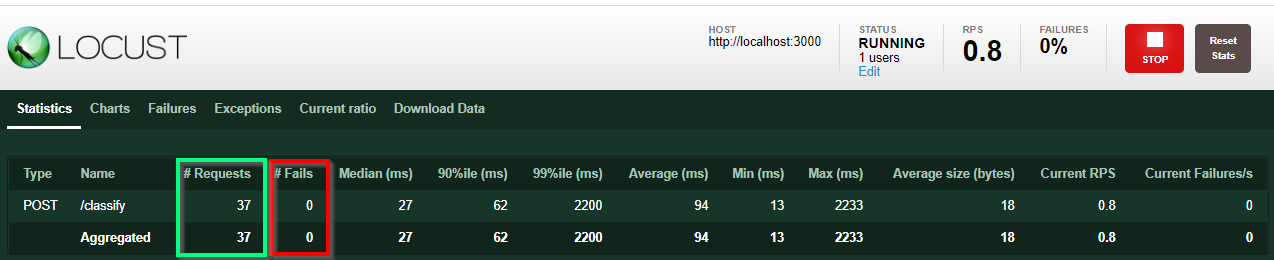

In [1]:
# download second model
!curl -O https://s3.us-west-2.amazonaws.com/bentoml.com/mlzoomcamp/coolmodel2.bentomodel

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1728  100  1728    0     0   1921      0 --:--:-- --:--:-- --:--:--  1922


In [2]:
!dir coolmodel*.bentomodel

 Volume in drive C has no label.
 Volume Serial Number is E8A5-BC16

 Directory of C:\Users\alain\Documents\prv\IT\mlzc\jupyter

20/10/2022  10:03             1,724 coolmodel.bentomodel
20/10/2022  17:23             1,728 coolmodel2.bentomodel
               2 File(s)          3,452 bytes
               0 Dir(s)  95,671,980,032 bytes free


In [3]:
!bentoml models import coolmodel2.bentomodel

Model(tag="mlzoomcamp_homework:jsi67fslz6txydu5") imported


In [4]:
!type C:\Users\alain\bentoml\models\mlzoomcamp_homework\jsi67fslz6txydu5\model.yaml

name: mlzoomcamp_homework
version: jsi67fslz6txydu5
module: bentoml.sklearn
labels: {}
options: {}
metadata: {}
context:
  framework_name: sklearn
  framework_versions:
    scikit-learn: 1.1.1
  bentoml_version: 1.0.7
  python_version: 3.9.12
signatures:
  predict:
    batchable: true
    batch_dim:
    - 0
    - 0
api_version: v1
creation_time: '2022-10-14T14:48:43.330446+00:00'


In [6]:
!type hw7_q6__service.py

print('***** Starting hw7_q6_service.py 17:41 *****')

import numpy as npy

import bentoml
from bentoml.io import JSON
from bentoml.io import NumpyNdarray

from pydantic import BaseModel

print('** Import completed**')

class UserProfile(BaseModel):
    name: str
    age: int
    country: str
    rating: float


print('** Get model **')

# for coolmodel.bentomodel Q5
#modBnt = bentoml.sklearn.get("mlzoomcamp_homework:qtzdz3slg6mwwdu5")

# for coolmodel2.bentomodel Q6
modBnt = bentoml.sklearn.get("mlzoomcamp_homework:jsi67fslz6txydu5")

print('** Run mmodel **')

modBntRun = modBnt.to_runner()


svc = bentoml.Service("hw7_q6_service", runners=[modBntRun])

@svc.api(input=NumpyNdarray(), output=JSON())

def classify(UserProfile):
    print('** in classify **')
    print('> UserProfile :' , UserProfile)
    prd = modBntRun.predict.run(UserProfile)
    print('> prd = ' , prd)
    return( { "prediction" : prd  })




### a) in miniconda bentoml + activate:
- cd C:\Users\alain\Documents\prv\IT\mlzc\jupyter
- bentoml serve hw7_q**6**__service:svc --reload **--production**
- check at http://localhost:3000/ that serrvice works
- open a second miniconda3 + activate

### b) in miniconda locust (an other one)
- cd C:\Users\alain\Documents\prv\IT\mlzc\jupyter
- locust -H http://localhost:3000
- check at http://localhost:8089 that locust works (default 1 user each second)  

## Model1
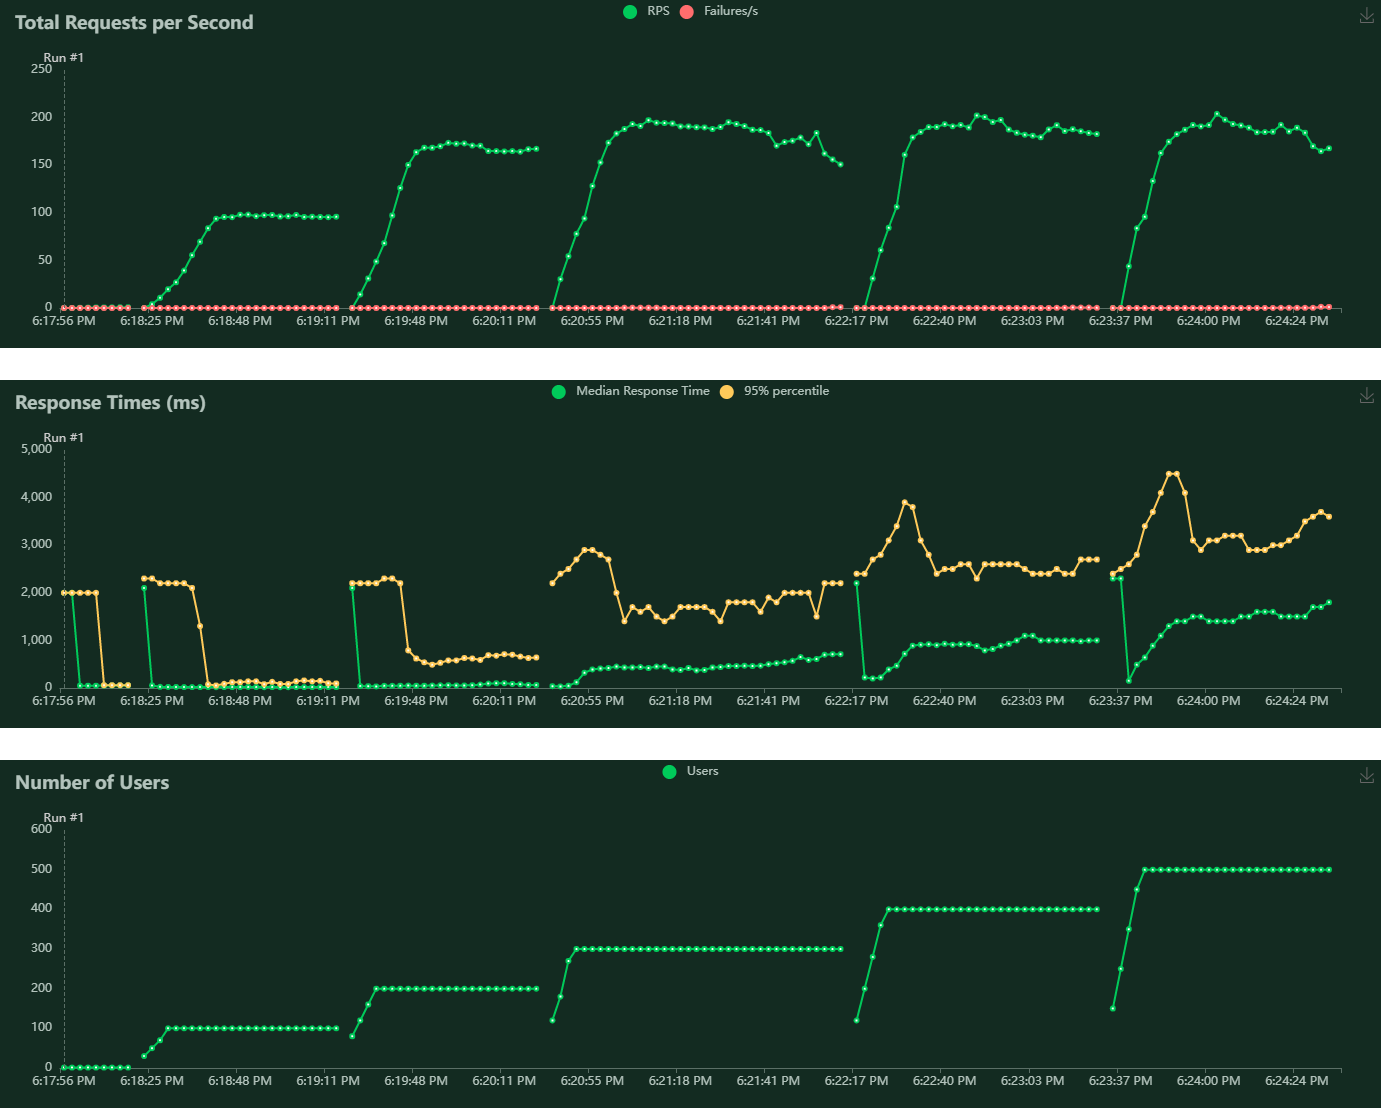

## Model2
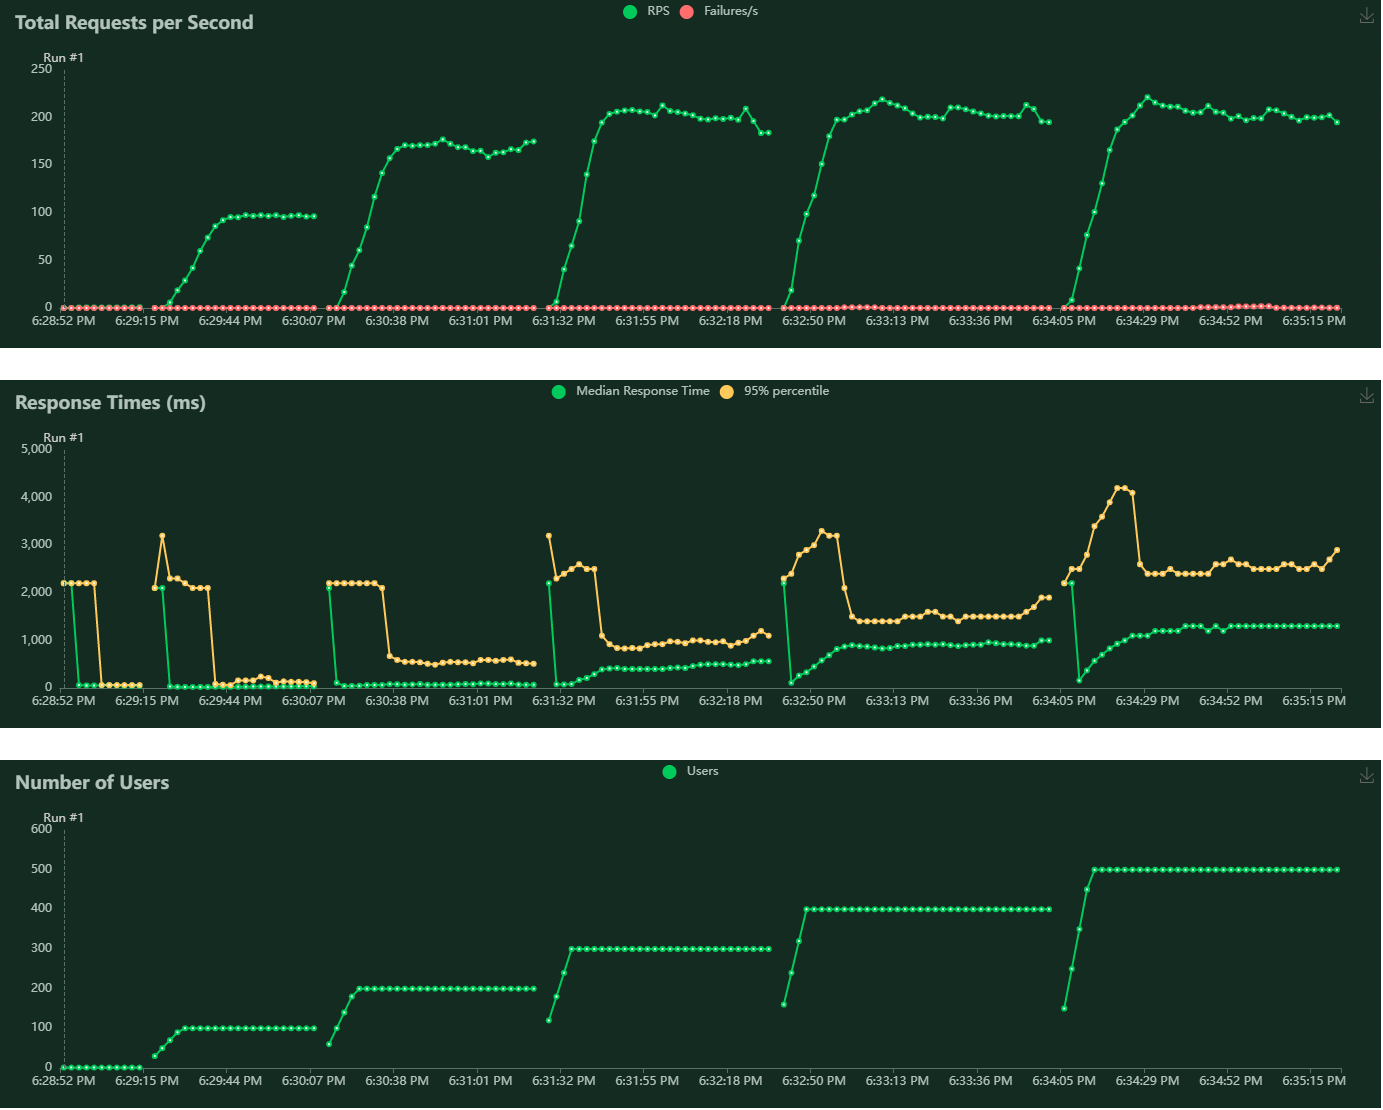

### Q6: Model2 faster (micro batching)

# Q7

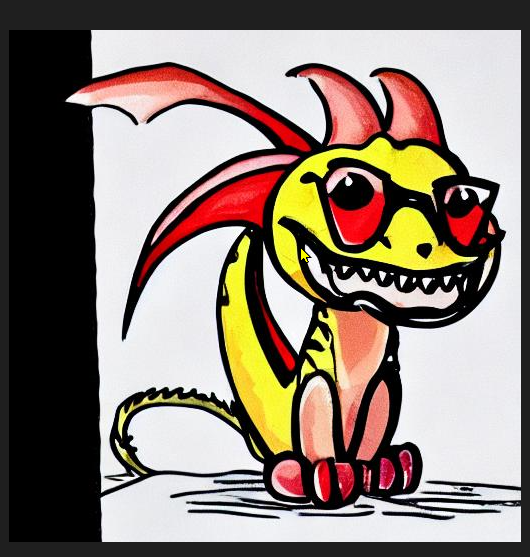

### Extra 

In [3]:
!bentoml models list

 Tag                          Module           Size        Creation Time       
 credit_risk_model:rneewusoâ€¦  bentoml.xgboost  197.77 KiB  2022-10-18 16:52:53 
 credit_risk_model:i6ft532oâ€¦  bentoml.xgboost  197.77 KiB  2022-10-18 16:50:59 
 credit_risk_model:5va73qkoâ€¦  bentoml.xgboost  197.77 KiB  2022-10-18 15:36:53 
 credit_risk_model:23jm4jkoâ€¦  bentoml.xgboost  197.77 KiB  2022-10-18 15:14:47 
 mlzoomcamp_homework:jsi67fâ€¦  bentoml.sklearn  5.82 KiB    2022-10-14 16:48:43 
 mlzoomcamp_homework:qtzdz3â€¦  bentoml.sklearn  5.79 KiB    2022-10-13 22:42:14 
